In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import haversine as hs
import random
import string
import xgboost as xgb
import seaborn as sns
from datetime import datetime
from hurricaneModels import HurricaneModel
from haversine import haversine, Unit
from sklearn import svm

## Pre-Processing

In [2]:
# Importing Data
data_folder = glob.glob('matToPyData/*.csv')
data_folder.sort()
data_list = []

for file in data_folder:
    print(file)
    df = pd.read_csv(file, header = None)
    df.drop(df.columns[3], inplace = True, axis = 1) # dropping fake numeric date
    data_list.append(df)



matToPyData/bestStormData_1.csv
matToPyData/bestStormData_2.csv
matToPyData/bestStormData_3.csv
matToPyData/bestStormData_4.csv
matToPyData/bestStormData_5.csv
matToPyData/bestStormData_6.csv
matToPyData/bestStormData_7.csv


In [3]:
# Importing Data Dates
dates_folder = glob.glob('matToPyDates/*.csv')
dates_folder.sort()
dates_list = []

for file in dates_folder:
    print(file)
    df = pd.read_csv(file, header = None)
    dates_list.append(df)

matToPyDates/bestStormDates_1.csv
matToPyDates/bestStormDates_2.csv
matToPyDates/bestStormDates_3.csv
matToPyDates/bestStormDates_4.csv
matToPyDates/bestStormDates_5.csv
matToPyDates/bestStormDates_6.csv
matToPyDates/bestStormDates_7.csv


### Feature Engineering

In [4]:
random.seed(10)
final_data_list = []
for i in range(0, len(dates_list)):
    df = pd.concat([data_list[i], dates_list[i]], axis = 1)
    df.columns = ['lat', 'long', 'distance', 'azimuth', 'speed', 'cp', 'windspeed', 
                  'landfall_flag', 'overland_flag', 'maxwind', 'min_cp','rad_maxwind', 'eye_diam', 'pressure_isobar', 'rad_isobar' ,'date_time']
    #print(df.shape)
    
    df = df[df['lat'].between(-90,90)] # removing impossible long lat values
    df = df[df['long'].between(-180,180)]
    
    #print(df.shape)

    df['SID'] = random.choice(string.ascii_uppercase) + '_' + str(i + 1) #assigning IDs

    df['date_time'] = pd.to_datetime(df['date_time']) # converting dates to timedate

    df['hour'] = df['date_time'].dt.hour
    df['day'] = df['date_time'].dt.day_of_week
    df['month'] = df['date_time'].dt.month
    final_data_list.append(df)

In [5]:
def haversine(lat1, lat2, lon1, lon2):
    p1 = (lat1, lon1)
    p2 = (lat2, lon2)
    return hs.haversine(p1, p2)

# Adding between point distance as a feature
for data in final_data_list:
    data.loc[0, 'derived_distance'] = 0
    for i in range(1, len(data)):
        data.loc[i, 'derived_distance'] = haversine(data.iloc[i-1, :]['lat'], 
                                                     data.iloc[i, :]['lat'], 
                                                     data.iloc[i-1, :]['long'], 
                                                     data.iloc[i, :]['long'])

In [6]:
# Exporting all final preprocessed data:
k = 1
for data in final_data_list:
    data.to_csv('/Users/jasonluo/Documents/Hurricane_proj/finalPreprocData/final_dataset' + str(k) + '.csv', 
                index = False)
    k += 1

## Analysis

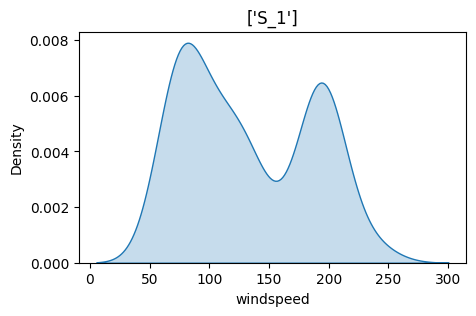

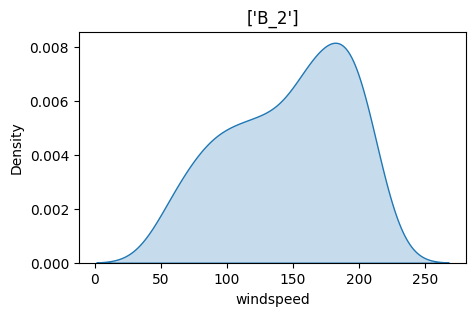

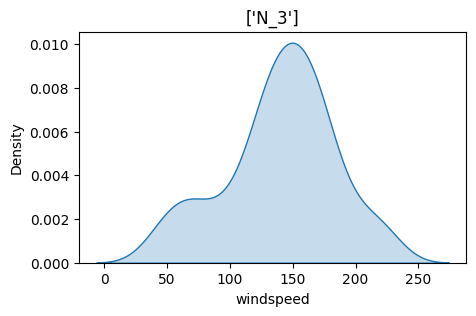

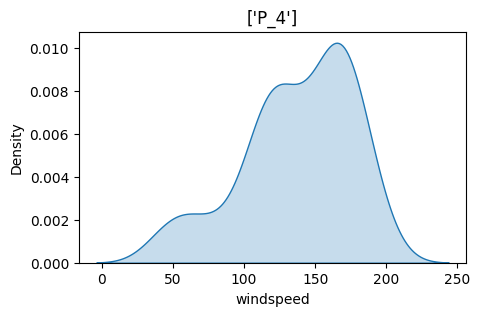

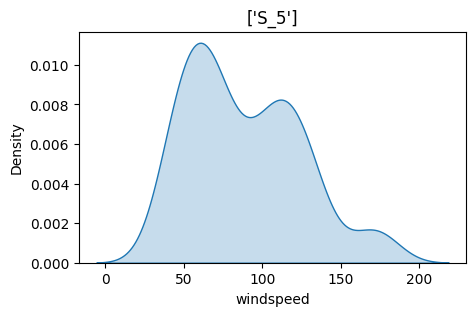

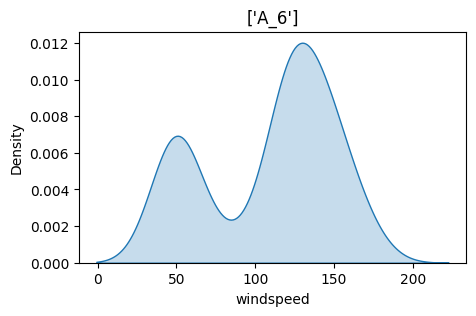

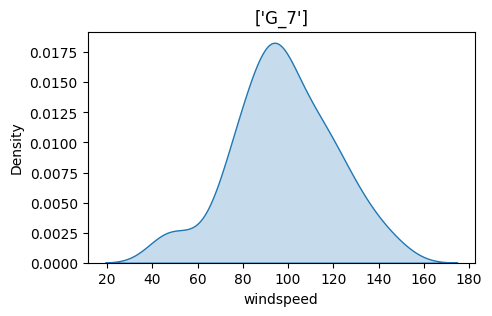

In [7]:

for i in range(0, len(final_data_list)):
    plt.figure(figsize = [5,3])
    plt.title(pd.unique(final_data_list[i]['SID']))
    sns.kdeplot(x = final_data_list[i]['windspeed'], 
                        fill = True)

['S_1'] MSE: 2760.3049965733203 MAE: 43.81141445489262 MAPE: 48.44329387455001
['B_2'] MSE: 1270.8801226750663 MAE: 28.457603682446976 MAPE: 21.47781056371685
['N_3'] MSE: 3289.77097304023 MAE: 51.42744084853134 MAPE: 39.95875264733611
['P_4'] MSE: 282.3612217072468 MAE: 13.838785855334928 MAPE: 9.475722285838632
['S_5'] MSE: 754.2277539735676 MAE: 23.244738109631108 MAPE: 20.743903796645643
['A_6'] MSE: 723.0949730921864 MAE: 21.482652524198006 MAPE: 20.315537592739215
['G_7'] MSE: 431.5843329979852 MAE: 17.22965358947116 MAPE: 17.557188126312813


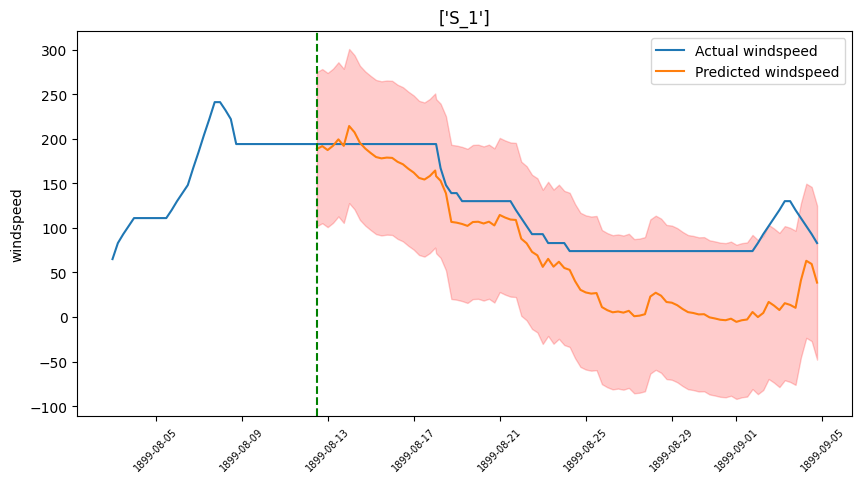

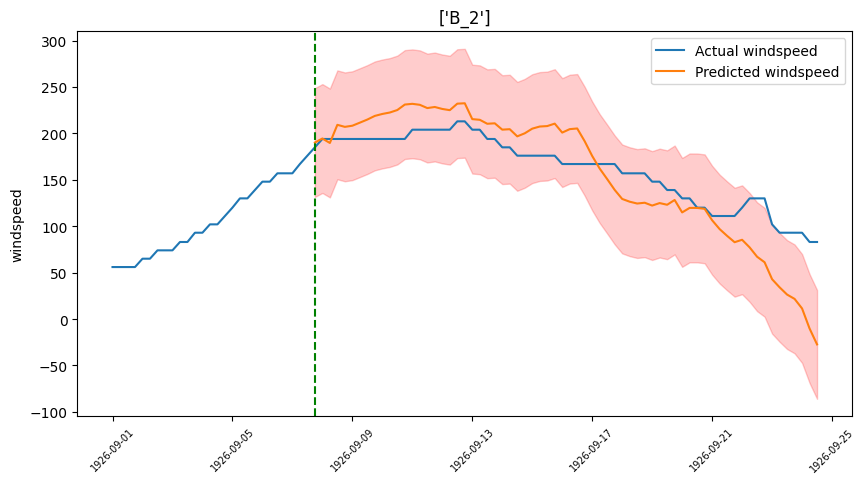

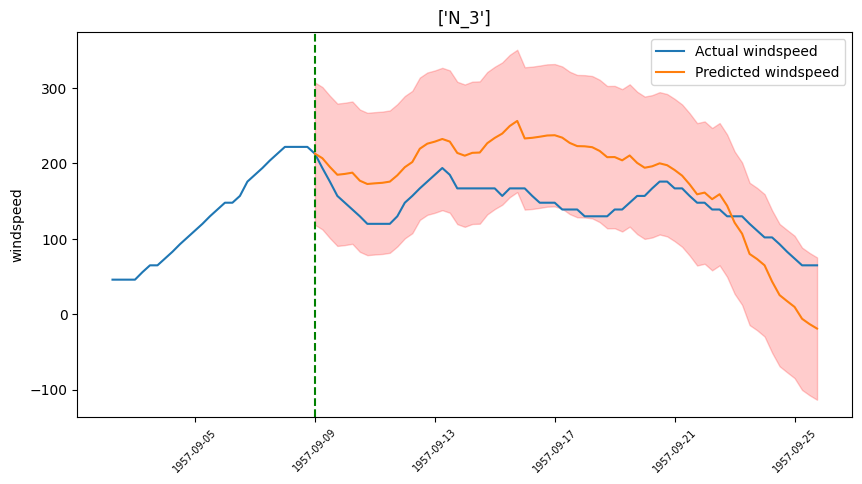

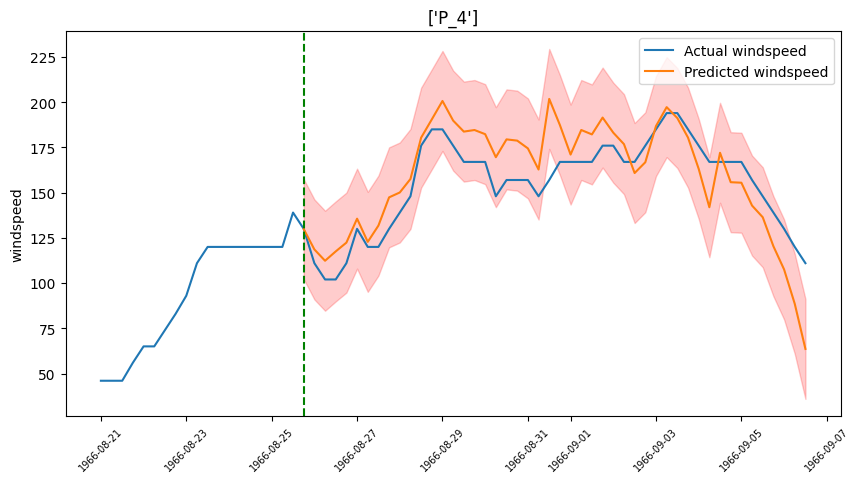

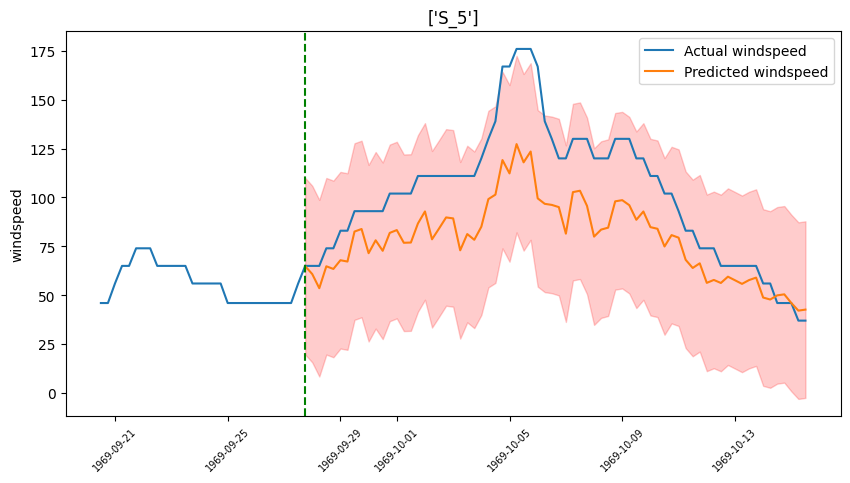

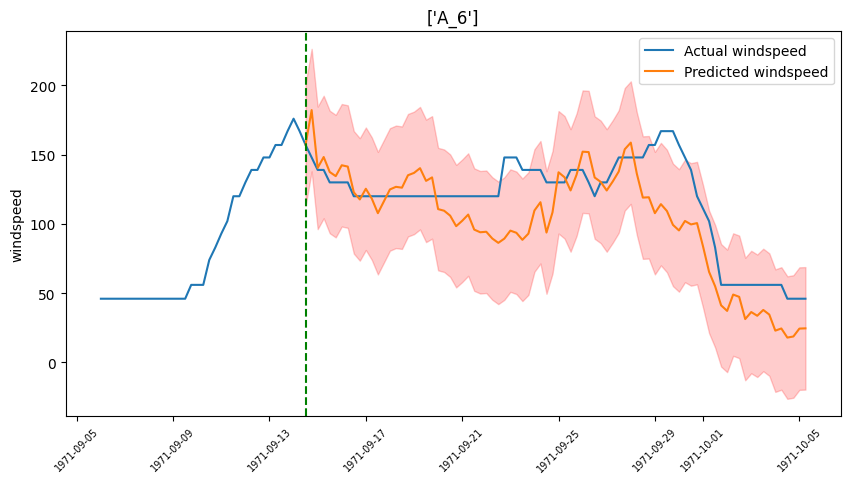

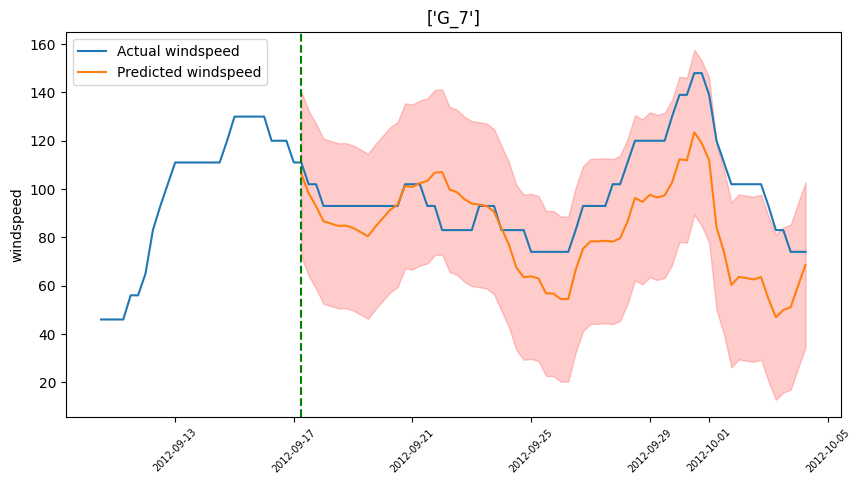

In [8]:
feats = ['lat', 'long', 'speed', 'cp', 'derived_distance', 'day', 'hour', 'month']
target = 'windspeed'
ratio = 0.3

model1 = xgb.XGBRegressor(n_estimators = 500, 
                          learning_rate = 0.01)
model2 = svm.SVR(kernel = 'linear', 
                 epsilon=0.2)

for data in final_data_list:
    Hmodel = HurricaneModel(model2, data)
    Hmodel.split_train_predict(ratio, feats, target, True)
    #Hmodel.plotACF(target)

['S_1'] MSE: 858.4230298069416 MAE: 22.180832148944454 MAPE: 24.410122651712758
['B_2'] MSE: 1689.8227074593578 MAE: 31.794199057949594 MAPE: 25.457415452995534
['N_3'] MSE: 1088.9822831971765 MAE: 29.54331675708422 MAPE: 23.80019296670394
['P_4'] MSE: 310.0591871399206 MAE: 15.324422032976514 MAPE: 9.844160314930443
['S_5'] MSE: 210.03811928059875 MAE: 12.346663233580342 MAPE: 11.222730171053641
['A_6'] MSE: 531.9123813762922 MAE: 20.413758877519047 MAPE: 20.778836245588707
['G_7'] MSE: 278.73486089924364 MAE: 13.976042433603869 MAPE: 14.263435603909524


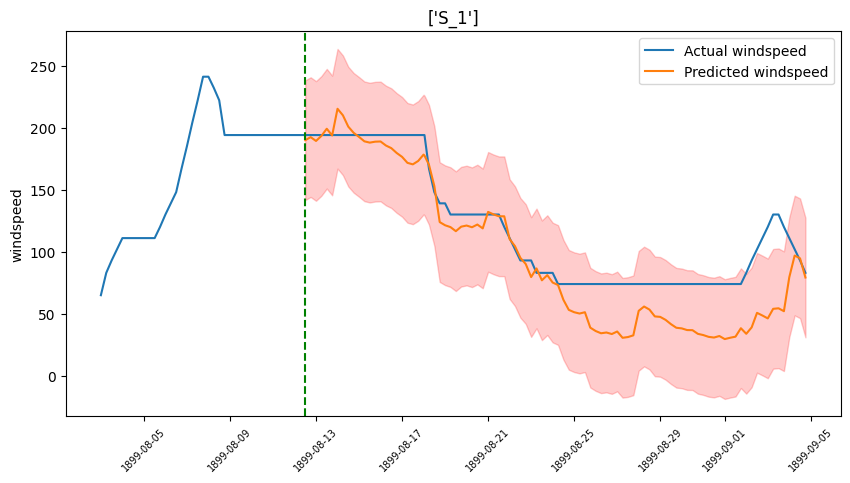

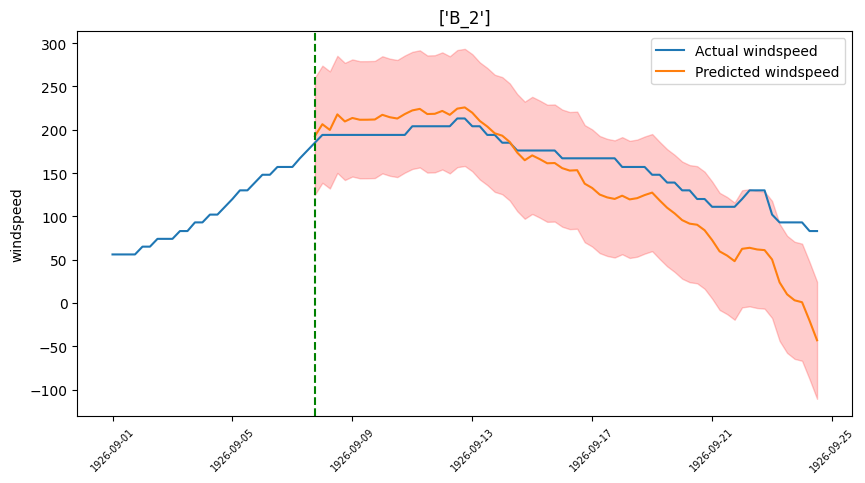

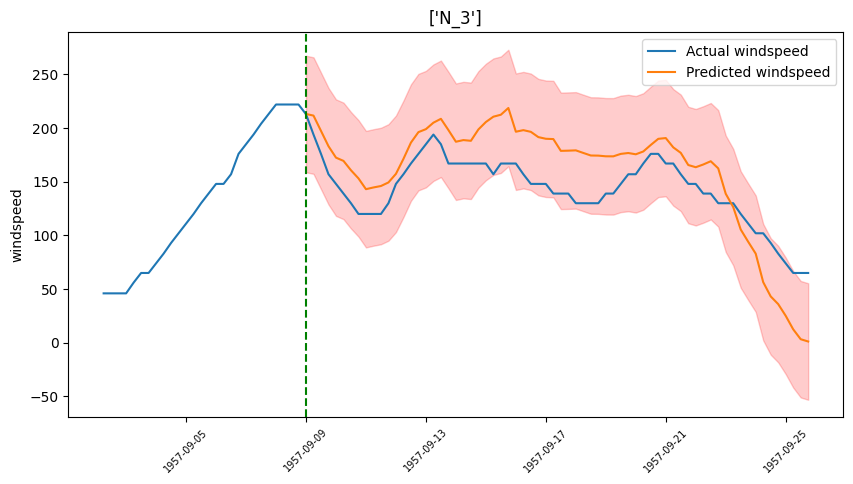

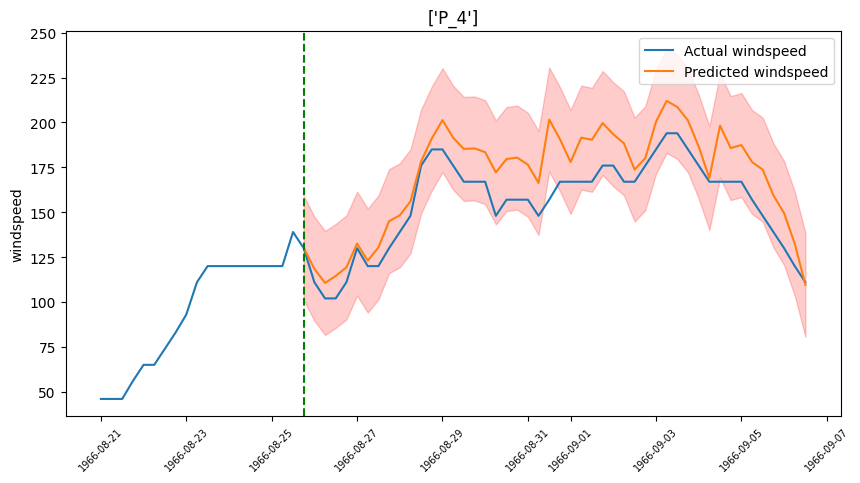

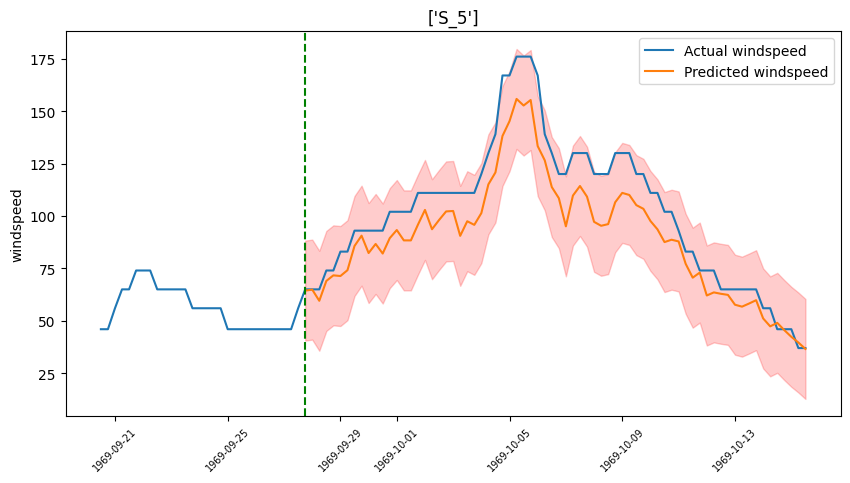

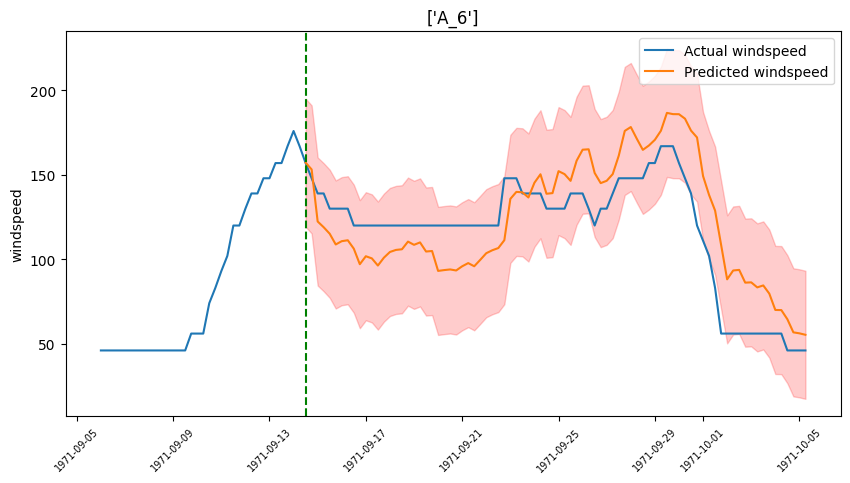

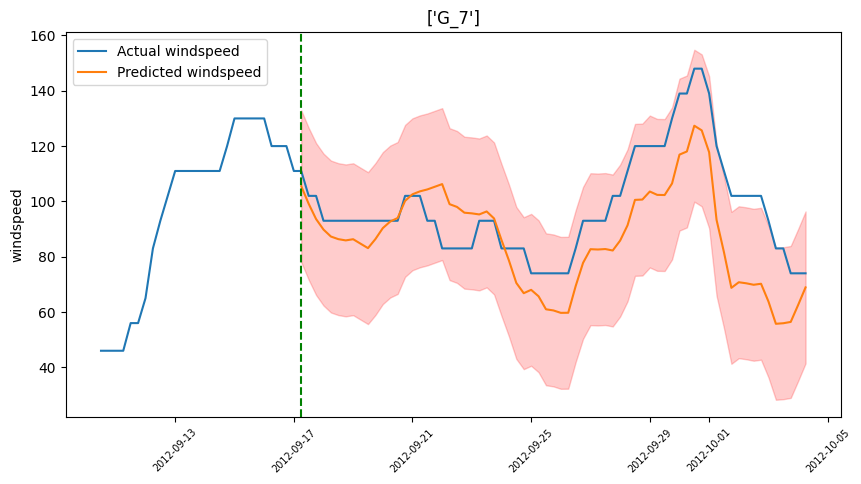

In [9]:
# With using lagged wind speed as a feature
# Lagged feature (in this case lagged windspeed) improves performance significantly

feats = ['lat', 'long', 'speed', 'cp', 'derived_distance', 'day', 'hour', 'month', 'windspeed_lag']
target = 'windspeed'
ratio = 0.3

for data in final_data_list:
    Hmodel = HurricaneModel(model2, data)
    Hmodel.addLaggedTarget(target, lag = 1)
    Hmodel.split_train_predict(ratio, feats, target, True)
    #Hmodel.plotACF(target)